# Fair NOS vs ML forecasters (signed residual z-score events)

**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.

Device: cpu


NOS simulation: 100%|██████████| 12000/12000 [00:00<00:00, 22075.01it/s]


Simulated V: (11000, 80)

Training MLP ...
[001] train 0.567621 | val 0.805928
[002] train 0.266607 | val 0.759492
[004] train 0.144807 | val 0.746276
[006] train 0.107822 | val 0.749545
[008] train 0.089397 | val 0.749811
[010] train 0.077310 | val 0.755236
[012] train 0.070827 | val 0.753871
Early stop.

Training RNN ...
[001] train 0.487577 | val 0.336963
[002] train 0.135924 | val 0.143262
[004] train 0.035419 | val 0.064850
[006] train 0.022010 | val 0.046208
[008] train 0.017027 | val 0.037131
[010] train 0.014447 | val 0.031901
[012] train 0.013091 | val 0.028609
[014] train 0.012221 | val 0.026430
[016] train 0.011732 | val 0.024929
[018] train 0.011261 | val 0.023698
[020] train 0.010962 | val 0.022929

Training GRU ...
[001] train 0.498435 | val 0.340033
[002] train 0.136706 | val 0.154290
[004] train 0.040812 | val 0.083261
[006] train 0.026145 | val 0.064949
[008] train 0.019262 | val 0.052948
[010] train 0.015480 | val 0.044307
[012] train 0.013356 | val 0.038551
[014] tra

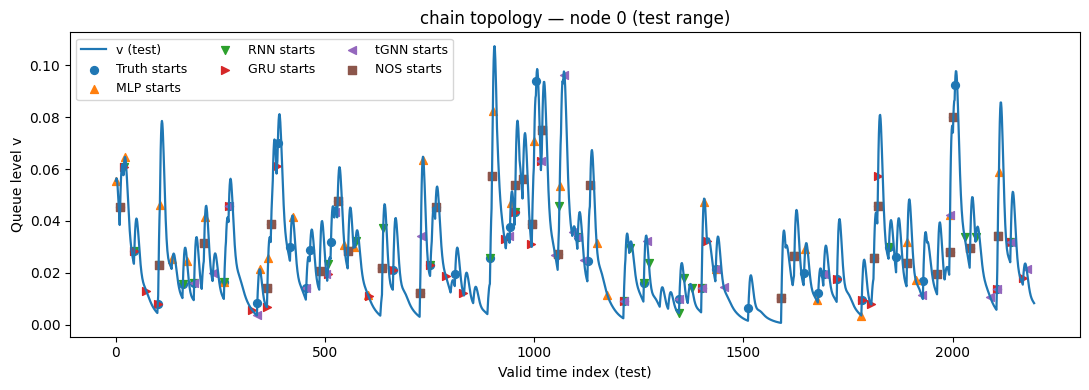

Saved metrics to outputs/nos_vs_forecasters_fair_signedz/nos_vs_forecasters_fair_signedz.csv


In [ ]:
# ============================================================
# NV3 Fair NOS vs tGNN / GRU / RNN / MLP — Label-free forecasting
# Signed residual z-score events (train-only fit), no padding
# One-figure overlay of Truth & all model starts (incl. NOS)
# IMPORTANT::Topology switch: "chain" | "star" | "scale_free"
# Assumes I_t > 0 in the simulator drive
# ==========================================================
import os
os.environ["TORCH_DISABLE_DYNAMO"] = "1"

import math, random
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

from pathlib import Path
import sys
from pathlib import Path as _Path
_REPO_ROOT = (_Path.cwd().parent if _Path.cwd().name.lower() == "notebooks" else _Path.cwd())
if str(_REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(_REPO_ROOT))

try:
    from src.nos import NOSParams as _NOSParams, nos_drift as _nos_drift
except Exception:
    try:
        from nos import NOSParams as _NOSParams, nos_drift as _nos_drift
    except Exception:
        _NOSParams = None
        _nos_drift = None

def _core_params_from_legacy(p):
    if _NOSParams is None:
        return None
    return _NOSParams(
        alpha=float(p.alpha), kappa=float(p.kappa),
        beta=float(p.beta), gamma=float(p.gamma),
        lam=float(p.lam), chi=float(p.chi), v_rest=float(p.v_rest),
        a=float(p.a), b=float(p.b), mu=float(p.mu),
        theta=float(getattr(p, "v_th", 1.0)),
        thresh_jitter_std=float(getattr(p, "sigma_th", 0.0)),
        rho_reset=float(getattr(p, "rho_reset", 1.0)),
        c_reset=float(getattr(p, "c", 0.0)),
        du_spike=float(getattr(p, "d", 0.0)),
        v_clip=None,
    )


# ----------------------------
# I/O settings
# ----------------------------
try:
    _HERE = Path(__file__).resolve().parent
except NameError:
    _HERE = Path.cwd()

if (_HERE / "src").exists():
    sys.path.insert(0, str(_HERE))
elif (_HERE.parent / "src").exists():
    sys.path.insert(0, str(_HERE.parent))

OUTDIR = os.path.join("outputs", "nos_vs_forecasters_fair_signedz")
os.makedirs(OUTDIR, exist_ok=True)
SAVE_FIGS = True

RECORD_V_PRE_RESET = True   # True reproduces original: record v before applying reset on a spike
NOS_PREDICTOR_MODE = "proxy"
ALLOW_EARLY_MATCH = False

# ---------
# Config
# ---------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

CFG = {
    "topology": "chain",         # "chain" | "star" | "scale_free"
    "N": 80,                     # nodes
    "T_total": 12000,            # total simulated steps (inc. burn)
    "T_burn": 1000,
    "dt": 0.2,                   # seconds per step (200 ms)
    "window": 24,
    "horizon": 1,
    "batch_size": 128,
    "epochs": 20,
    "patience": 6,
    "lr": 2e-3,
    "train_frac": 0.6,
    "val_frac": 0.2,
    "hidden": 128,
    "gnn_hidden": 128,
    "use_ax_as_feature": True,   # fairness: give all models [x_t, (A x)_t]
    # Event detection (SIGNED residuals)
    "Z_HI": 2.5,                 # turn ON when z >= Z_HI
    "Z_LO": 1.0,                 # turn OFF when z <  Z_LO
    "MIN_DUR": 3,
    "WINDOW_STEPS": 10,
    "plot_node": 0,
    "num_workers": 0,
}

# --------------------------------
# Topology, weights, delays utilities
# -----------------------------------
def build_W_and_delays(topology: str, N: int,
                       p_weight=(0.4, 1.0), delay_steps=(1, 5)):
    if topology == "chain":
        G = nx.path_graph(N)
    elif topology == "star":
        G = nx.star_graph(N - 1)
    else:
        m = max(2, int(0.02 * N))
        G = nx.barabasi_albert_graph(N, m, seed=SEED)

    W = np.zeros((N, N), dtype=np.float32)
    rng = np.random.default_rng(SEED)
    for u, v in G.edges():
        W[u, v] = rng.uniform(*p_weight)
        W[v, u] = rng.uniform(*p_weight)

    rs = W.sum(axis=1, keepdims=True); rs[rs == 0.0] = 1.0
    Wn = W / rs

    dmin, dmax = delay_steps
    D = rng.integers(dmin, dmax + 1, size=(N, N))
    D[Wn == 0.0] = 0
    return Wn.astype(np.float32), D.astype(np.int32)

W, D = build_W_and_delays(CFG["topology"], CFG["N"])
N = W.shape[0]

A_hat = W + np.eye(N, dtype=np.float32)
A_hat = (A_hat.T / (A_hat.sum(axis=1) + 1e-8)).T

# ----------------------
# NOS simulator
# -------------------
@dataclass
class NOSParams:
    alpha: float = 1.0
    kappa: float = 1.0
    beta: float = 0.0
    gamma: float = 0.0
    lam: float = 0.35
    chi: float = 0.12
    a: float = 0.9
    b: float = 1.3
    mu: float = 0.2
    v_rest: float = 0.0
    v_th: float = 0.9
    sigma_th: float = 0.02
    c: float = 0.18
    d: float = 0.05
    rho_reset: float = 4.0
    rho_noise: float = 0.06
    A_min: float = 0.01
    A_max: float = 0.05
    tau_s: float = 5.0
    g: float = 0.9

class NOSSim:
    def __init__(self, W, D, dt=0.2, params: NOSParams = NOSParams(), seed=SEED):
        self.W, self.D = W, D
        self.N = W.shape[0]; self.dt = dt
        self.p = params
        self.rng = np.random.default_rng(seed)
        self.buffers = [dict() for _ in range(self.N)]

    def f_sat(self, v):
        p = self.p
        return (p.alpha * v * v) / (1.0 + p.kappa * v * v)

    def simulate(self, T_total, T_burn):
        N, dt, p = self.N, self.dt, self.p
        p_core = _core_params_from_legacy(p)
        v = np.clip(self.rng.normal(0.05, 0.01, size=N), 0.0, 1.0)
        u = np.zeros(N, dtype=np.float64)
        eta = np.zeros(N, dtype=np.float64)
        records_v = []

        for t in tqdm(range(T_total), desc="NOS simulation"):
            # shot noise arrivals (I_t > 0)
            eta *= math.exp(-dt / max(p.tau_s, 1e-6))
            arrivals = self.rng.poisson(p.rho_noise, size=N)
            if arrivals.any():
                amps = self.rng.uniform(p.A_min, p.A_max, size=N)
                eta += amps * (arrivals > 0).astype(np.float64)

            # deliver buffered spikes
            I = np.zeros(N, dtype=np.float64)
            for s in range(N):
                if t in self.buffers[s]:
                    for j, w in self.buffers[s][t]:
                        I[j] += p.g * w
            for s in range(N):
                if t in self.buffers[s]:
                    del self.buffers[s][t]
            I += eta
            if _nos_drift is None or p_core is None:
                dv = self.f_sat(v) + p.beta * v + p.gamma - u + I - p.lam * v - p.chi * (v - p.v_rest)
                du = p.a * (p.b * v - u) - p.mu * u
            else:
                dv, du = _nos_drift(v, u, I, p_core)
            v = np.clip(v + dt * dv, 0.0, 2.5)
            u = u + dt * du
            if p_core is None:
                th = p.v_th + self.rng.normal(0.0, p.sigma_th, size=N)
            else:
                th = p_core.theta + self.rng.normal(0.0, p_core.thresh_jitter_std, size=N)
            fired = v >= th

            if t >= T_burn and RECORD_V_PRE_RESET:

                records_v.append(v.copy())
            if fired.any():
                if p_core is None:
                    v[fired] = p.c + (v[fired] - p.c) * math.exp(-p.rho_reset * dt)
                    u[fired] = u[fired] + p.d
                else:
                    pull = math.exp(-p_core.rho_reset * dt)
                    v[fired] = p_core.c_reset + (v[fired] - p_core.c_reset) * pull
                    u[fired] = u[fired] + p_core.du_spike

                if t >= T_burn and (not RECORD_V_PRE_RESET):
                    records_v.append(v.copy())
                src = np.where(fired)[0]
                for s in src:
                    nbrs = np.nonzero(self.W[s])[0]
                    for j in nbrs:
                        w = self.W[s, j]
                        if w <= 0: continue
                        delay = int(self.D[s, j])
                        t_deliver = t + delay
                        if t_deliver not in self.buffers[s]:
                            self.buffers[s][t_deliver] = []
                        self.buffers[s][t_deliver].append((j, w))

        V = np.asarray(records_v, dtype=np.float32)  # [T_valid_raw, N]
        return V

nos = NOSSim(W, D, dt=CFG["dt"])
V = nos.simulate(CFG["T_total"], CFG["T_burn"])     # [T, N]
T = V.shape[0]
print("Simulated V:", V.shape)

# -------------------------------
# Valid indices, splits, scaling
# -------------------------------
WIN, H = CFG["window"], CFG["horizon"]
valid_t = np.arange(WIN, T - H + 1)

n_all = len(valid_t)
n_tr = int(CFG["train_frac"] * n_all)
n_va = int((CFG["train_frac"] + CFG["val_frac"]) * n_all)
valid_tr = valid_t[:n_tr]
valid_va = valid_t[n_tr:n_va]
valid_te = valid_t[n_va:]


V_tr_windows = np.stack([V[t - WIN:t] for t in valid_tr], axis=0)   # [B_tr, WIN, N]
mu_node = V_tr_windows.reshape(-1, N).mean(axis=0)
std_node = V_tr_windows.reshape(-1, N).std(axis=0) + 1e-6

def standardise(seq):   # [T, N]
    return (seq - mu_node[None, :]) / std_node[None, :]

def unstandardise(seq_std):
    return seq_std * std_node[None, :] + mu_node[None, :]

V_std = standardise(V)

# ---------------------------
# Full-graph window dataset
# ---------------------------
class GraphWindowSTD(Dataset):
    def __init__(self, V_std, idxs, win, horizon, use_ax=False, A=None):
        self.Vs = V_std.astype(np.float32)  # [T, N]
        self.idxs = idxs
        self.win = win; self.h = horizon
        self.use_ax = use_ax
        self.A = None if A is None else torch.from_numpy(A.astype(np.float32))
    def __len__(self): return len(self.idxs)
    def __getitem__(self, q):
        t = self.idxs[q]
        X = self.Vs[t - self.win:t]                 # [WIN, N]
        y = self.Vs[t + self.h - 1]                 # [N]
        if self.use_ax and self.A is not None:
            # augment per time step with (A @ x_t)
            AX = (self.A.numpy() @ X.T).T
            X = np.concatenate([X, AX], axis=1)     # [WIN, 2N]
        return torch.from_numpy(X), torch.from_numpy(y)

ds_tr = GraphWindowSTD(V_std, valid_tr, WIN, H, use_ax=CFG["use_ax_as_feature"], A=A_hat)
ds_va = GraphWindowSTD(V_std, valid_va, WIN, H, use_ax=CFG["use_ax_as_feature"], A=A_hat)
ds_te = GraphWindowSTD(V_std, valid_te, WIN, H, use_ax=CFG["use_ax_as_feature"], A=A_hat)

dl_tr = DataLoader(ds_tr, batch_size=CFG["batch_size"], shuffle=True,
                   num_workers=CFG["num_workers"], pin_memory=False)
dl_va = DataLoader(ds_va, batch_size=CFG["batch_size"], shuffle=False,
                   num_workers=CFG["num_workers"], pin_memory=False)

# --------------
# Forecasters
# --------------
class MLPForecaster(nn.Module):
    def __init__(self, win, in_dim_per_t, hidden, N_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                              # (WIN, in_dim) -> WIN*in_dim
            nn.Linear(win * in_dim_per_t, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, N_out)
        )
    def forward(self, X):  # X: [B, WIN, in_dim_per_t]
        return self.net(X)

class RNNForecaster(nn.Module):
    def __init__(self, in_dim_per_t, hidden, N_out):
        super().__init__()
        self.rnn = nn.RNN(in_dim_per_t, hidden, batch_first=True)
        self.out = nn.Linear(hidden, N_out)
    def forward(self, X):  # [B, WIN, in_dim_per_t]
        Y, _ = self.rnn(X)
        return self.out(Y[:, -1, :])

class GRUForecaster(nn.Module):
    def __init__(self, in_dim_per_t, hidden, N_out):
        super().__init__()
        self.gru = nn.GRU(in_dim_per_t, hidden, batch_first=True)
        self.out = nn.Linear(hidden, N_out)
    def forward(self, X):
        Y, _ = self.gru(X)
        return self.out(Y[:, -1, :])

class tGNNForecaster(nn.Module):
    """
    'True' MP: at each step feed [x_t, (A x_t)] if enabled.
    No learnable N->N mixing other than generic RNN weights shared with other models.
    """
    def __init__(self, in_dim_per_t, hidden, N_out):
        super().__init__()
        self.gru = nn.GRU(in_dim_per_t, hidden, batch_first=True)
        self.out = nn.Linear(hidden, N_out)
    def forward(self, X):
        Y, _ = self.gru(X)
        return self.out(Y[:, -1, :])

def build_models(in_dim_per_t, N_out):
    H = CFG["hidden"]; HG = CFG["gnn_hidden"]
    models = {
        "MLP":  MLPForecaster(WIN, in_dim_per_t, H,  N_out),
        "RNN":  RNNForecaster(in_dim_per_t, H, N_out),
        "GRU":  GRUForecaster(in_dim_per_t, H, N_out),
        "tGNN": tGNNForecaster(in_dim_per_t, HG, N_out),
    }
    return models

# ----------------
# Train utilities
# ----------------
def train_model(model, dl_tr, dl_va, epochs, lr, patience):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best = float("inf"); best_state = None; wait = 0
    for ep in range(epochs):
        model.train(); tr = 0.0
        for xb, yb in dl_tr:
            xb = xb.to(DEVICE).float(); yb = yb.to(DEVICE).float()
            opt.zero_grad()
            yhat = model(xb)
            loss = F.mse_loss(yhat, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tr += loss.item() * xb.size(0)
        tr /= len(dl_tr.dataset)

        model.eval(); va = 0.0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb = xb.to(DEVICE).float(); yb = yb.to(DEVICE).float()
                va += F.mse_loss(model(xb), yb).item() * xb.size(0)
        va /= len(dl_va.dataset)

        if (ep + 1) % 2 == 0 or ep == 0:
            print(f"[{ep+1:03d}] train {tr:.6f} | val {va:.6f}")

        if va + 1e-6 < best:
            best = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stop.")
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

# -------------
# Train models
# -------------
in_dim_per_t = N * (2 if CFG["use_ax_as_feature"] else 1)
models = build_models(in_dim_per_t, N)
trained = {}
for name, m in models.items():
    print(f"\nTraining {name} ...")
    trained[name] = train_model(m, dl_tr, dl_va,
                                epochs=CFG["epochs"], lr=CFG["lr"], patience=CFG["patience"])

# -----------------------------
# Rolling forecasts (no padding)
# -----------------------------
@torch.no_grad()
def roll_forecast_whole(model, V_std, idxs, win, use_ax=False, A=None):
    model.eval(); model.to(DEVICE)
    preds_std = np.zeros((len(idxs), N), dtype=np.float32)
    for k, t in enumerate(idxs):
        X = V_std[t - win:t]                                 # [WIN, N]
        if use_ax and A is not None:
            AX = (A @ X.T).T
            X = np.concatenate([X, AX], axis=1)              # [WIN, in_dim_per_t]
        xb = torch.from_numpy(X).unsqueeze(0).to(DEVICE).float()
        yhat = model(xb).squeeze(0).detach().cpu().numpy()
        preds_std[k] = yhat
    # back to original scale
    P = preds_std * std_node[None, :] + mu_node[None, :]
    Y = V[idxs + (H - 1)]
    return P.astype(np.float32), Y.astype(np.float32)

# NOS one-step forecaster + simple calibration
def nos_one_step_proxy(V_last, params: NOSParams, dt, I_hat):
    """Legacy NOS one-step proxy: u_t ≈ 0.6 v_t; I_hat = A v_t.
    Uses nos.py drift when available so the formula is a single source of truth.
    """
    v_t = V_last
    u_t = np.clip(0.6 * v_t, 0.0, 2.5)

    p_core = _core_params_from_legacy(params)
    if _nos_drift is None or p_core is None:
        f_sat = (params.alpha * v_t * v_t) / (1.0 + params.kappa * v_t * v_t)
        dv = f_sat + params.beta * v_t + params.gamma - u_t + I_hat - params.lam * v_t - params.chi * (v_t - params.v_rest)
    else:
        dv, _du = _nos_drift(v_t, u_t, I_hat, p_core)

    return np.clip(v_t + dt * dv, 0.0, 2.5)

def nos_one_step_stateful(V_last, U_last, params: NOSParams, dt, I_hat):
    v_t = V_last
    u_t = U_last

    p_core = _core_params_from_legacy(params)
    if _nos_drift is None or p_core is None:
        f_sat = (params.alpha * v_t * v_t) / (1.0 + params.kappa * v_t * v_t)
        dv = f_sat + params.beta * v_t + params.gamma - u_t + I_hat - params.lam * v_t - params.chi * (v_t - params.v_rest)
        du = params.a * (params.b * v_t - u_t) - params.mu * u_t
    else:
        dv, du = _nos_drift(v_t, u_t, I_hat, p_core)

    v_next = np.clip(v_t + dt * dv, 0.0, 2.5)
    u_next = u_t + dt * du
    return v_next, u_next

def nos_one_step(V_last, params: NOSParams, dt, I_hat, U_last=None):
    """Dispatch between legacy proxy and stateful predictor."""
    if NOS_PREDICTOR_MODE == "stateful":
        if U_last is None:
            U_last = np.zeros_like(V_last)
        return nos_one_step_stateful(V_last, U_last, params, dt, I_hat)
    else:
        return nos_one_step_proxy(V_last, params, dt, I_hat)

def nos_forecast_series(V, idxs, dt, A):
    P = np.zeros((len(idxs), N), dtype=np.float32)

    if NOS_PREDICTOR_MODE == "stateful":
        U = np.zeros(N, dtype=np.float32)
        for k, t in enumerate(idxs):
            v_last = V[t - 1]
            I_hat = (A @ v_last)
            v_next, U = nos_one_step(v_last, nos.p, dt, I_hat, U_last=U)
            P[k] = v_next
    else:
        for k, t in enumerate(idxs):
            v_last = V[t - 1]
            I_hat = (A @ v_last)
            P[k] = nos_one_step(v_last, nos.p, dt, I_hat)

    Y = V[idxs + (H - 1)]
    return P.astype(np.float32), Y.astype(np.float32)

def calibrate_nos_on_train(V, idxs_tr, dt, A, steps=120):
    # random search over {lam, chi, alpha, kappa} on train next-step MSE
    rng = np.random.default_rng(SEED)
    bounds = dict(lam=(0.05, 1.0), chi=(0.00, 0.6), alpha=(0.2, 2.5), kappa=(0.2, 3.0))
    def clamp(x, a, b): return max(a, min(b, x))
    def trial_loss(pp):
        keep = {**nos.p.__dict__, **pp}
        p_tmp = NOSParams(**keep)
        errs = []
        for t in idxs_tr:
            v_last = V[t - 1]
            I_hat = (A @ v_last)
            pred = nos_one_step(v_last, p_tmp, dt, I_hat)
            target = V[t + (H - 1)]
            errs.append(np.mean((pred - target) ** 2))
        return float(np.mean(errs))

    best = dict(lam=nos.p.lam, chi=nos.p.chi, alpha=nos.p.alpha, kappa=nos.p.kappa)
    best_L = trial_loss(best)
    for _ in range(steps):
        prop = dict(
            lam=clamp(best["lam"] + rng.normal(0, 0.05), *bounds["lam"]),
            chi=clamp(best["chi"] + rng.normal(0, 0.03), *bounds["chi"]),
            alpha=clamp(best["alpha"] + rng.normal(0, 0.10), *bounds["alpha"]),
            kappa=clamp(best["kappa"] + rng.normal(0, 0.10), *bounds["kappa"]),
        )
        L = trial_loss(prop)
        if L < best_L:
            best, best_L = prop, L
    nos.p.lam, nos.p.chi, nos.p.alpha, nos.p.kappa = best["lam"], best["chi"], best["alpha"], best["kappa"]

# Calibrate NOS on TRAIN only
calibrate_nos_on_train(V, valid_tr, CFG["dt"], A_hat)

# Roll all models on splits
def roll_all(models, split_idxs, tag):
    P = {}; Y = {}
    for name, m in models.items():
        P[name], Y[name] = roll_forecast_whole(m, V_std, split_idxs, WIN,
                                               use_ax=CFG["use_ax_as_feature"], A=A_hat)
    # NOS
    P["NOS"], Y["NOS"] = nos_forecast_series(V, split_idxs, CFG["dt"], A_hat)
    return P, Y

P_tr, Y_tr = roll_all(trained, valid_tr, "train")
P_va, Y_va = roll_all(trained, valid_va, "val")
P_te, Y_te = roll_all(trained, valid_te, "test")

# --------------------------------------------
# Label-free events: train-calibrated SIGNED z
# --------------------------------------------
def z_fit_signed(P_tr, Y_tr):
    R = (Y_tr - P_tr)
    med = np.median(R, axis=0)
    mad = np.median(np.abs(R - med[None, :]), axis=0) + 1e-8
    scale = 1.4826 * mad
    return med.astype(np.float32), scale.astype(np.float32)

def z_apply_signed(P, Y, med, scale):
    R = (Y - P)
    Z = (R - med[None, :]) / scale[None, :]
    return Z

def hysteresis_starts_from_Z_signed(Z, hi, lo, min_dur):
    T, N = Z.shape
    above = Z >= hi
    below = Z <  lo
    active = np.zeros((T, N), dtype=bool)
    for j in range(N):
        on = False; run = 0
        for t in range(T):
            if not on:
                if above[t, j]:
                    on = True; run = 1; active[t, j] = True
            else:
                if below[t, j]:
                    if run < min_dur:
                        active[t - run:t, j] = False
                    on = False; run = 0
                else:
                    active[t, j] = True; run += 1
        if on and run < min_dur:
            active[T - run:T, j] = False
    starts = active & (~np.vstack([np.zeros((1, N), dtype=bool), active[:-1]]))
    return starts.astype(np.uint8), active.astype(np.uint8)

def match_events_within_window(truth_starts, pred_starts, window_steps):
    """
    Legacy: counts a hit only if predicted start is at/after truth within window.
    If ALLOW_EARLY_MATCH=True, allows matches in [t0-window, t0+window] and returns signed latency.
    """
    T, N = truth_starts.shape
    tp_mask = np.zeros((T, N), dtype=bool); lat = []
    for j in range(N):
        Tj = np.where(truth_starts[:, j] == 1)[0]
        Pj = np.where(pred_starts[:, j]  == 1)[0]
        used = np.zeros(len(Pj), dtype=bool)
        for t0 in Tj:
            if len(Pj) == 0:
                continue
            if ALLOW_EARLY_MATCH:
                delays = Pj - t0
                ok = np.where((~used) & (np.abs(delays) <= window_steps))[0]
                if len(ok):
                    kbest = ok[np.argmin(np.abs(delays[ok]))]
                    used[kbest] = True
                    tp_mask[Pj[kbest], j] = True
                    lat.append(int(delays[kbest]))
            else:
                k0 = np.searchsorted(Pj, t0, side="left")
                if k0 < len(Pj) and (Pj[k0] - t0) <= window_steps and (not used[k0]):
                    used[k0] = True
                    tp_mask[Pj[k0], j] = True
                    lat.append(int(Pj[k0] - t0))
    return tp_mask, lat

def prf1(tp_mask, truth_starts, pred_starts):
    tp = int(tp_mask.sum())
    fp = int(pred_starts.sum() - tp_mask.sum())
    fn = int(truth_starts.sum() - tp_mask.sum())
    P = tp / (tp + fp + 1e-9)
    R = tp / (tp + fn + 1e-9)
    F1 = 2 * P * R / (P + R + 1e-9)
    return P, R, F1

# Build "truth" from naive one-step baseline (train-calibrated signed z)
Yhat_naive_tr = V[valid_tr - 1]
Yhat_naive_te = V[valid_te - 1]
med_T, scale_T = z_fit_signed(Yhat_naive_tr, V[valid_tr])
Z_truth_te = z_apply_signed(Yhat_naive_te, V[valid_te], med_T, scale_T)
truth_starts_te, _ = hysteresis_starts_from_Z_signed(
    Z_truth_te, CFG["Z_HI"], CFG["Z_LO"], CFG["MIN_DUR"]
)

# Per-model fit on TRAIN; evaluate on TEST (same thresholds)
def evaluate_on_test(name, P_tr, Y_tr, P_te, Y_te):
    med, scale = z_fit_signed(P_tr, Y_tr)
    Z_te = z_apply_signed(P_te, Y_te, med, scale)
    pred_starts_te, _ = hysteresis_starts_from_Z_signed(
        Z_te, CFG["Z_HI"], CFG["Z_LO"], CFG["MIN_DUR"]
    )
    tp_mask, lat = match_events_within_window(truth_starts_te, pred_starts_te, CFG["WINDOW_STEPS"])
    Pn, Rn, F1 = prf1(tp_mask, truth_starts_te, pred_starts_te)
    mae = float(np.mean(np.abs(P_te - Y_te)))
    rmse = float(np.sqrt(np.mean((P_te - Y_te) ** 2)))
    lat_med = float(np.median(lat) * CFG["dt"] * 1000.0) if len(lat) else float("nan")
    lat_p90 = float(np.percentile(lat, 90) * CFG["dt"] * 1000.0) if len(lat) else float("nan")
    return dict(Model=name, F1=F1, Precision=Pn, Recall=Rn,
                Latency_ms_med=lat_med, Latency_ms_p90=lat_p90,
                MAE=mae, RMSE=rmse, starts=pred_starts_te)

rows = []
starts_dict = {}

for name in ["MLP", "RNN", "GRU", "tGNN", "NOS"]:
    res = evaluate_on_test(
        name,
        P_tr[name], Y_tr[name],
        P_te[name], Y_te[name]
    )
    rows.append({k: res[k] for k in res if k not in ("starts",)})
    starts_dict[name] = res["starts"]

df = pd.DataFrame(rows).sort_values("F1", ascending=False).reset_index(drop=True)
print("\n=== Fair label-free residual-event benchmark (SIGNED z) ===")
print(df.to_string(index=False))
print("Truth starts (test):", int(truth_starts_te.sum()))

# ------------------------------------------------
# One example figure (test window, one node) with
# truth + all model starts (including NOS)
# ------------------------------------------------
node = CFG["plot_node"]
t0 = 0
Tte = len(valid_te)
v_plot = V[valid_te + (H - 1), node]  # true v on test range
x_axis = np.arange(Tte)

plt.figure(figsize=(11, 4))
plt.plot(x_axis, v_plot, lw=1.6, label="v (test)")

# truth markers
truth_idx = np.where(truth_starts_te[:, node] == 1)[0]
plt.scatter(truth_idx, v_plot[truth_idx], s=32, c="C0", marker="o", label="Truth starts")

# model markers
markers = dict(MLP="^", RNN="v", GRU=">", tGNN="<", NOS="s")
colors  = dict(MLP="C1", RNN="C2", GRU="C3", tGNN="C4", NOS="C5")
for name in ["MLP", "RNN", "GRU", "tGNN", "NOS"]:
    idx = np.where(starts_dict[name][:, node] == 1)[0]
    plt.scatter(idx, v_plot[idx], s=32, marker=markers[name], c=colors[name], label=f"{name} starts")

plt.title(f"{CFG['topology']} topology — node {node} (test range)")
plt.xlabel("Valid time index (test)")
plt.ylabel("Queue level v")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(os.path.join(OUTDIR, f"example_starts_{CFG['topology']}_node{node}.png"), dpi=240)
plt.show()


df_out = df.copy()
df_out["Topology"] = CFG["topology"]
df_out.to_csv(os.path.join(OUTDIR, "nos_vs_forecasters_fair_signedz.csv"), index=False)
df_out.to_csv(os.path.join(OUTDIR, f"nos_vs_forecasters_fair_signedz_{CFG['topology']}.csv"), index=False)
print("Saved metrics to", os.path.join(OUTDIR, "nos_vs_forecasters_fair_signedz.csv"))

# -----------------
# Quick usage notes
# -----------------
# 1) Change topology:
#    CFG["topology"] = "star"       # or "scale_free"
#    then rerun the entire file.
# 2) Event thresholds (SIGNED residuals):
#    Increase Z_HI to reduce positives; lower Z_LO to extend ON states.
# 3) Detection latency is reported in milliseconds (steps * dt).
